# Kalman Filter with forgetting

<div style='text-align: justify;'>
Kalman filter is a state-space method that provides a framework to estimate the time-varying parameter (TVP) between two variables. As the relationship between the stock market indices
is not constant, this setting can estimate their dynamic linkages. This TVP has a similar notion with the beta coefficient of the OLS. Their difference is that the parameter of a simple regression is constant over-time. In portfolio construction decisions, when the TVP between two market indices is increasing, then the markets are more interdependent and the chances of achieving diversification benefits are decreasing. On this research, the Kalman filter specification that is used, was proposed by (Koop & Korobilis, 2012).
    </div>

<div style='text-align: justify;'>
Following a similar procedure with (Dunis & Shannon, 2005), the time-varying relationship between the US and the emerging countries is investigated using a bivariate Kalman filter with forgetting. For the Kalman filter and by taking into consideration the daily frequency of the data, the forgetting parameter (λ) is 0.94 and the decay factor (κ) is 0.96. 
    </div>

In [1]:
def kalman(df):
    # Kalman Filter with intercept
    # This code was proposed by Korobilis and taught by juhee during the 8th lec of applied time series
    # Check the slides and the corresponding code
    if isinstance(df, np.ndarray) != True:
        df = df.to_numpy()
    x = df[:, 1]
    y = df[:, 0]
    con = np.ones((len(df[:, 1]),))
    x = np.column_stack((con, x))
    T, p = x.shape
    # Forgetting and decay factors
    l = 0.94
    k = 0.96

    # Initialization
    btt1 = np.zeros((T, p))
    btt = np.zeros((T, p))  # updated mean
    Ptt1 = np.zeros((p, p, T))  # predicted variance

    # For each t, p x p matrix will be saved
    Ptt = np.zeros((p, p, T))  # updated variance
    v = np.zeros((T, 1))  # forecast error
    sigma_tilde = np.zeros((T, 1))  # variance

    # Initial condition for Kalman filter b(0) ~ N(b0,P0)
    b0 = np.zeros((1, p))
    P0 = np.diag(np.ones(p) * 10)
    s0 = 0.1

    for t in range(T):
        # Predict step
        if t == 0:
            btt1[t] = b0
            Ptt1[:, :, t] = (1 / l) * P0
        else:
            btt1[t] = btt[t - 1, :]
            Ptt1[:, :, t] = (1 / l) * Ptt[:, :, t - 1]
        # Update step
        v[t] = y[t] - np.dot(x[t, :], btt1[t].T)  # forecast error
        # EWMA estimate of the volatility
        if t == 0:
            sigma_tilde[t] = k * s0 + (1 - k) * (v[t] ** 2)
        else:
            sigma_tilde[t] = k * sigma_tilde[t - 1] + (1 - k) * (v[t] ** 2)
        S = (sigma_tilde[t] + np.dot(np.dot(x[t], Ptt1[:, :, t]), x[t].T)) ** (-1)  # variance of forecast error
        K = (np.dot(Ptt1[:, :, t], x[t].T)) * S  # Kalman gain
        btt[t] = btt1[t] + (K * v[t]).T  # updated mean
        Ptt[:, :, t] = Ptt1[:, :, t] - K * x[t] * Ptt1[:, :, t].T  # updated variance
    beta_Kalman = btt  # Final Kalman-filter based point estimate
    return beta_Kalman

In [2]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [10]:
def import_data(path):
    # The data were downloaded from investment.com
    # Load Market index logarithmic returns
    df = pd.read_csv(path)

    # Change column name
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Convert string to date time
    df['Date'] = pd.to_datetime(df['Date'])

    # Remove time
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Set frequency to avoid errors later in the VAR model
    df['Date'] = pd.DatetimeIndex(df['Date']).to_period('B')
    #df['Date'] = pd.DatetimeIndex(df['Date'])
    # Set Datetime index
    df.set_index('Date', inplace=True)
    return df

In [12]:
# Import Returns
path1="market_indexes_ret.csv"
market_return = import_data(path1)


In [13]:
# Market indices selection
dev_country = 'US'
developed_countries = ['US', 'Germany']
market_columns = market_return.columns.values
emerging = [country for country in market_columns if country not in developed_countries]
dates=market_return[dev_country].index.to_timestamp(freq=None, how='start')

## Plot the results

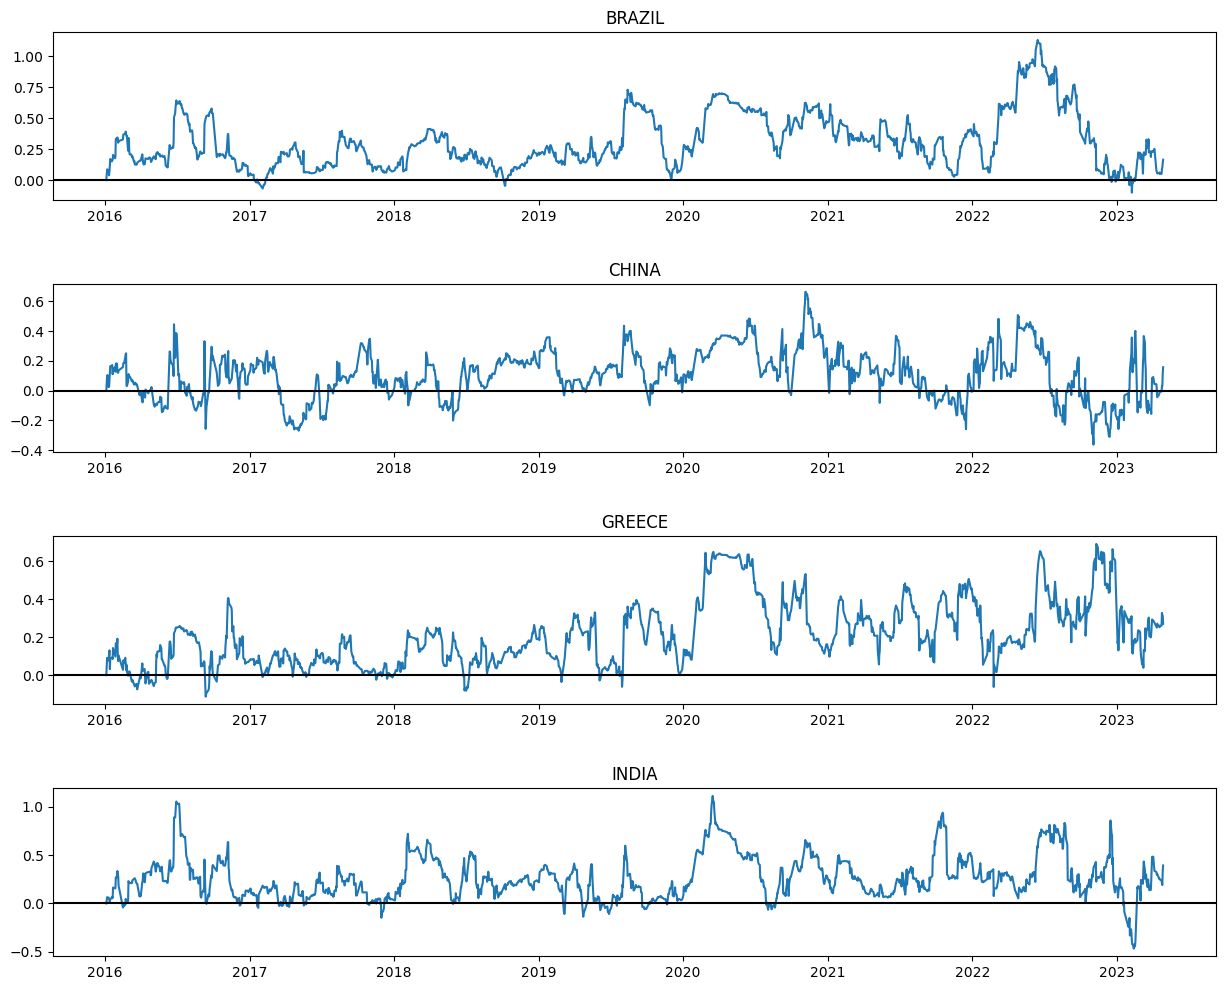

In [15]:
fig, axs = plt.subplots(nrows=len(emerging), ncols=1, figsize=(15, 12))
fig.subplots_adjust(hspace=.5,wspace=0.4)

# loop through tickers and axes
for market, ax in zip(emerging, axs.ravel()):
    rt = market_return[[dev_country, market]]

    # Run Kalman Filter
    beta_Kalman = kalman(rt)

    # Assign constant and slope to variables
    alpha_k = beta_Kalman[:, 0]
    beta_k = pd.DataFrame(beta_Kalman[:, 1])

    beta_k.set_index(dates, inplace=True)
    ax.plot(beta_k)
    ax.axhline(y=0, color='black', linestyle='-')

    # chart formatting
    ax.set_title(market.upper())
    ax.get_legend()
    ax.set_xlabel("")

plt.show()

### Results
The figure shows that only China should be used in a diversification strategy because after 2022, the integration between the US and China is decreasing.

## References
* Dunis, C., & Shannon, G. (2005). Emerging markets of South-East and Central Asia: Do they still offer a diversification benefit? Journal of Asset Management, 6, 168-190. doi:https://doi.org/10.1057/palgrave.jam.2240174
* Koop, G., & Korobilis, D. (2012). FORECASTING INFLATION USING DYNAMIC MODEL AVERAGING. International Economic Review, 53(3), 867-886. doi:https://doi.org/10.1111/j.1468-2354.2012.00704.x